# Notes

In [2]:
import sys
print(sys.prefix)
def get_base_prefix_compat():
    """Get base/real prefix, or sys.prefix if there is none."""
    return getattr(sys, "base_prefix", None) or getattr(sys, "real_prefix", None) or sys.prefix

def in_virtualenv():
    return get_base_prefix_compat() != sys.prefix

in_virtualenv()

c:\Users\jvnhe\Projects\Names


True

https://gitlab.com/cpbl/google-ngrams/-/tree/master

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213554

https://pudding.cool/2020/06/karen

https://anna.ps/blog/baby-name-data

https://www.nature.com/articles/s41597-021-01047-x

https://bl.iro.bl.uk/concern/datasets/f9ff33ab-56b7-4594-8aca-49781296c0c6?locale=en

https://betterprogramming.pub/convert-text-to-phoneme-in-python-989b6e05b70f

https://github.com/koaning/whatlies?s=03

https://www.economist.com/britain/2021/11/18/britains-inequalities-are-spelt-out-in-its-surnames

https://www.theguardian.com/lifeandstyle/2022/aug/12/why-do-baby-names-go-in-and-out-of-fashion-we-ask-an-expert?CMP=Share_AndroidApp_Other

Name features
- letters
- length
- phonemes? 
- embeddings - similarity?
- co-occurence - words more / less likely

Name distribution similarity with USA

Predict most popular names / biggest rises

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from whatlies import EmbeddingSet
from whatlies.embedding import Embedding
from sklearn.metrics.pairwise import cosine_similarity
from getngrams import getNgrams
import time
import json

# Load data

In [32]:
def load_data_UK_1996_to_2020():
  df_ONS_1996_2020 = pd.read_excel(r"Names data\babynames1996to2020.xls", sheet_name = "Boys", skiprows = 3)
  years = list(df_ONS_1996_2020.columns[1::2])
  df_ONS_1996_2020 = df_ONS_1996_2020[df_ONS_1996_2020.columns[::2]].iloc[1:-7]
  df_ONS_1996_2020.columns = ["name"] + years
  df_ONS_1996_2020 = df_ONS_1996_2020[list(set(df_ONS_1996_2020.columns))]
  df_ONS_1996_2020 = df_ONS_1996_2020.melt( id_vars = ['name'], value_vars = set(list(years)))
  df_ONS_1996_2020['sex'] = 'male'
  df_ONS_1996_2020.columns = ['name', 'year', 'count', 'sex']

  df_ONS_1996_2020_r = pd.read_excel(r"Names data\babynames1996to2020.xls", sheet_name = "Boys", skiprows = 3)
  years = list(df_ONS_1996_2020_r.columns[1::2])
  df_ONS_1996_2020_r = df_ONS_1996_2020_r[list([df_ONS_1996_2020_r.columns[0]]) + list(df_ONS_1996_2020_r.columns[1::2])].iloc[1:-7]
  df_ONS_1996_2020_r.columns = ["name"] + years
  df_ONS_1996_2020_r = df_ONS_1996_2020_r[list(set(df_ONS_1996_2020_r.columns))]
  df_ONS_1996_2020_r = df_ONS_1996_2020_r.melt( id_vars = ['name'], value_vars = set(list(years)))
  df_ONS_1996_2020_r['sex'] = 'male'
  df_ONS_1996_2020_r.columns = ['name', 'year', 'rank', 'sex']

  df_ONS_1996_2020['rank'] = df_ONS_1996_2020_r['rank']

  df_ONS_1996_20202 = pd.read_excel(r"Names data\babynames1996to2020.xls", sheet_name = "Girls", skiprows = 3)
  years = list(df_ONS_1996_20202.columns[1::2])
  df_ONS_1996_20202 = df_ONS_1996_20202[df_ONS_1996_20202.columns[::2]].iloc[1:-7]
  df_ONS_1996_20202.columns = ["name"] + years
  df_ONS_1996_20202 = df_ONS_1996_20202[list(set(df_ONS_1996_20202.columns))]
  df_ONS_1996_20202 = df_ONS_1996_20202.melt( id_vars = ['name'], value_vars = set(list(years)))
  df_ONS_1996_20202['sex'] = 'female'
  df_ONS_1996_20202.columns = ['name', 'year', 'count', 'sex']

  df_ONS_1996_20202_r = pd.read_excel(r"Names data\babynames1996to2020.xls", sheet_name = "Girls", skiprows = 3)
  years = list(df_ONS_1996_20202_r.columns[1::2])
  df_ONS_1996_20202_r = df_ONS_1996_20202_r[list([df_ONS_1996_20202_r.columns[0]]) + list(df_ONS_1996_20202_r.columns[1::2])].iloc[1:-7]
  df_ONS_1996_20202_r.columns = ["name"] + years
  df_ONS_1996_20202_r = df_ONS_1996_20202_r[list(set(df_ONS_1996_20202_r.columns))]
  df_ONS_1996_20202_r = df_ONS_1996_20202_r.melt(id_vars = ['name'], value_vars = set(list(years)))
  df_ONS_1996_20202_r['sex'] = 'male'
  df_ONS_1996_20202_r.columns = ['name', 'year', 'rank', 'sex']

  df_ONS_1996_20202['rank'] = df_ONS_1996_20202_r['rank']

  return pd.concat([df_ONS_1996_2020,df_ONS_1996_20202], axis = 0, ignore_index = True)[['name','year','sex','count','rank']]

def load_data_USA_y1_to_y2(y1,y2):
  x = pd.DataFrame()
  for i in range(y1,y2+1):
    y = pd.read_csv(r'Names data\USA_names\yob'+str(i)+'.txt', header = None)
    y.columns = ['name', 'sex', 'count']
    y['year'] = i
    x = pd.concat([x,y], axis = 0, ignore_index = True)
  x['sex'] = x['sex'].replace('F', 'female').replace('M', 'male')
  x['name'] = [i.upper() for i in USA_1996_2020['name']]
  return x[['name','year','sex','count']]

In [33]:
df_ONS_1996_2020 = load_data_UK_1996_to_2020()
df_ONS_1996_2020['count'] = df_ONS_1996_2020['count'].replace(":", 0)
df_ONS_1996_2020['rank'] = df_ONS_1996_2020['rank'].replace(":", np.nan)
df_ONS_1996_2020['percentage change'] = df_ONS_1996_2020.sort_values(['year']).groupby(['name','sex'])[['count']].pct_change().replace(np.inf, np.nan)
df_ONS_1996_2020['absolute change'] = df_ONS_1996_2020.sort_values(['year']).groupby(['name','sex'])[['count']].diff()
df_ONS_1996_2020['name'] = [str(x) for x in df_ONS_1996_2020['name']]

# Analysis

## Noah

In [34]:
df_ONS_1996_2020[(df_ONS_1996_2020['name'] == 'NOAH') & (df_ONS_1996_2020['sex'] == 'male')][['name', 'year', 'count']]

# "So it's not gonna be easy.
# It's gonna be really hard, and we're gonna have to work at this every day.
# But I wanna do that because I want you.
# I want all of you, forever, you and me, every day.
# Will you do something for me?
# Please?
# Will you just picture your life for me?
# Thirty years from now?
# Forty years from now?
# What's it look like?
# If it's with that guy, go. Go!
# I lost you once.
# I think I can do it again if I thought it's what you really wanted.
# But don't you take the easy way out."

# Noah (The Notebook - 2004)

,name,year,count
11217,NOAH,1996,137
27589,NOAH,1997,216
43961,NOAH,1998,242
60333,NOAH,1999,284
76705,NOAH,2000,281
93077,NOAH,2001,320
109449,NOAH,2002,404
125821,NOAH,2003,597
142193,NOAH,2004,880
158565,NOAH,2005,1346


## UK growth rates

### YoY

In [35]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'female') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['absolute change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='percentage change').head(10)

,name,year,sex,count,rank,percentage change,absolute change
519896,BRITTANY,2001,female,26,871.0,-0.814286,-114.0
793797,TULISA,2013,female,33,1075.0,-0.738095,-93.0
498473,BRITTANY,2000,female,140,275.0,-0.725490,-370.0
649083,CHENAI,2007,female,18,1443.0,-0.714286,-45.0
809061,MYLIE,2014,female,17,1702.0,-0.706897,-41.0
902927,ALEXA,2019,female,39,920.0,-0.669492,-79.0
701420,MIKA,2009,female,28,1105.0,-0.650000,-52.0
663021,SHANI,2007,female,19,1384.0,-0.648148,-35.0
822237,ELSA,2015,female,190,262.0,-0.646182,-347.0
711584,ASHLEE,2010,female,23,1332.0,-0.646154,-42.0


In [36]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'female') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['absolute change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='percentage change').tail(10)

,name,year,sex,count,rank,percentage change,absolute change
753443,AMELIA:LILLY,2012,female,32,1075.0,9.666667,29.0
606234,CHELSY,2005,female,32,866.0,9.666667,29.0
614349,LYLA,2005,female,139,303.0,10.583333,127.0
449161,SHOLA,1997,female,35,689.0,10.666667,32.0
789793,REEVA,2013,female,40,925.0,12.333333,37.0
672498,EMME,2008,female,66,573.0,15.500000,62.0
540180,ASHANTI,2002,female,71,445.0,16.750000,67.0
541848,CHARDONNAY,2002,female,58,513.0,18.333333,55.0
525981,KACI,2001,female,142,275.0,34.500000,138.0
477044,BRITNEY,1999,female,314,148.0,38.250000,306.0


In [37]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'female') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['absolute change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='absolute change').head(10)

,name,year,sex,count,rank,percentage change,absolute change
499225,CHLOE,2000,female,7534,1.0,-0.166408,-1504.0
774846,AMELIA,2013,female,5570,1.0,-0.211160,-1491.0
542071,CHLOE,2002,female,5708,1.0,-0.182703,-1276.0
607894,ELLIE,2005,female,4049,5.0,-0.212563,-1093.0
448826,SHANNON,1997,female,3640,16.0,-0.217036,-1009.0
551170,MEGAN,2002,female,4576,6.0,-0.179928,-1004.0
763841,LILY,2012,female,3802,5.0,-0.201428,-959.0
548999,LAUREN,2002,female,3513,11.0,-0.211625,-943.0
519547,BETHANY,2001,female,2805,17.0,-0.247989,-925.0
482768,JESSICA,1999,female,4799,8.0,-0.160867,-920.0


In [38]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'female') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['absolute change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='absolute change').tail(10)

,name,year,sex,count,rank,percentage change,absolute change
543625,ELLIE,2002,female,4854,4.0,0.265381,1018.0
437830,GEORGIA,1997,female,4908,10.0,0.318292,1185.0
721871,MAISIE,2010,female,2930,14.0,0.720493,1227.0
640448,RUBY,2006,female,4511,4.0,0.432518,1362.0
630755,GRACE,2006,female,5026,1.0,0.375855,1373.0
619025,RUBY,2005,female,3149,12.0,0.903869,1495.0
435200,COURTNEY,1997,female,2812,18.0,1.337490,1609.0
488738,OLIVIA,1999,female,5250,4.0,0.478873,1700.0
456379,CHLOE,1998,female,9628,1.0,0.243125,1883.0
753423,AMELIA,2012,female,7061,1.0,0.397111,2007.0


In [39]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'male') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['percentage change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='absolute change').head(10)

,name,year,sex,count,rank,percentage change,absolute change
291056,RILEY,2013,male,3122,21.0,-0.352953,-1703.0
256998,OLIVER,2011,male,7007,2.0,-0.168506,-1420.0
52400,CONNOR,1999,male,3786,22.0,-0.265567,-1369.0
36282,DANIEL,1998,male,7732,4.0,-0.145352,-1315.0
19910,DANIEL,1997,male,9047,4.0,-0.124879,-1291.0
284230,HARRY,2013,male,5888,3.0,-0.178571,-1280.0
72430,JAMES,2000,male,7489,3.0,-0.143919,-1259.0
41981,LIAM,1998,male,3486,24.0,-0.265022,-1257.0
105764,JORDAN,2002,male,1634,43.0,-0.414127,-1155.0
104138,HARRY,2002,male,4551,11.0,-0.196220,-1111.0


In [40]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'male') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['percentage change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='absolute change').tail(10)

,name,year,sex,count,rank,percentage change,absolute change
169626,HARRY,2006,male,5639,5.0,0.215826,1001.0
240626,OLIVER,2010,male,8427,1.0,0.144351,1063.0
44446,OWEN,1998,male,1896,40.0,1.332103,1083.0
235926,JACOB,2010,male,4308,12.0,0.340386,1094.0
71394,HARRY,2000,male,6070,6.0,0.235246,1156.0
222267,LUCAS,2009,male,3276,17.0,0.557775,1173.0
289960,OSCAR,2013,male,4511,7.0,0.371542,1222.0
180985,ALFIE,2007,male,5014,10.0,0.354403,1312.0
258312,RILEY,2011,male,4226,13.0,0.571004,1536.0
115497,ALFIE,2003,male,3450,17.0,1.641654,2144.0


In [41]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'male') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['absolute change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='absolute change').head(10)

,name,year,sex,count,rank,percentage change,absolute change
291056,RILEY,2013,male,3122,21.0,-0.352953,-1703.0
256998,OLIVER,2011,male,7007,2.0,-0.168506,-1420.0
52400,CONNOR,1999,male,3786,22.0,-0.265567,-1369.0
36282,DANIEL,1998,male,7732,4.0,-0.145352,-1315.0
19910,DANIEL,1997,male,9047,4.0,-0.124879,-1291.0
284230,HARRY,2013,male,5888,3.0,-0.178571,-1280.0
72430,JAMES,2000,male,7489,3.0,-0.143919,-1259.0
41981,LIAM,1998,male,3486,24.0,-0.265022,-1257.0
105764,JORDAN,2002,male,1634,43.0,-0.414127,-1155.0
104138,HARRY,2002,male,4551,11.0,-0.196220,-1111.0


In [42]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change'].isna() == False) & (df_ONS_1996_2020['sex'] == 'male') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['absolute change'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='absolute change').tail(10)

,name,year,sex,count,rank,percentage change,absolute change
169626,HARRY,2006,male,5639,5.0,0.215826,1001.0
240626,OLIVER,2010,male,8427,1.0,0.144351,1063.0
44446,OWEN,1998,male,1896,40.0,1.332103,1083.0
235926,JACOB,2010,male,4308,12.0,0.340386,1094.0
71394,HARRY,2000,male,6070,6.0,0.235246,1156.0
222267,LUCAS,2009,male,3276,17.0,0.557775,1173.0
289960,OSCAR,2013,male,4511,7.0,0.371542,1222.0
180985,ALFIE,2007,male,5014,10.0,0.354403,1312.0
258312,RILEY,2011,male,4226,13.0,0.571004,1536.0
115497,ALFIE,2003,male,3450,17.0,1.641654,2144.0


### 2016 v 2020

In [43]:
df_ONS_1996_2020['absolute change 1996 to 2020'] = df_ONS_1996_2020.sort_values(['year']).groupby(['name','sex'])[['count']].diff(24)
df_ONS_1996_2020['percentage change 1996 to 2020'] = df_ONS_1996_2020.sort_values(['year']).groupby(['name','sex'])[['count']].pct_change(24).replace(np.inf, np.nan)

In [44]:
df_ONS_1996_2020[(df_ONS_1996_2020['percentage change 1996 to 2020'].isna() == False) & (df_ONS_1996_2020['sex'] == 'male') & ((df_ONS_1996_2020['count'] - df_ONS_1996_2020['absolute change 1996 to 2020'] >= 50) | (df_ONS_1996_2020['count'] >= 30))].sort_values(by='absolute change 1996 to 2020').head(10)

,name,year,sex,count,rank,percentage change,absolute change,absolute change 1996 to 2020,percentage change 1996 to 2020
396466,DANIEL,2020,male,1203,50.0,-0.221359,-342.0,-9135.0,-0.883633
399632,JACK,2020,male,2900,10.0,-0.142266,-481.0,-7879.0,-0.730958
399870,JAMES,2020,male,1977,24.0,-0.153682,-359.0,-7408.0,-0.789345
407821,THOMAS,2020,male,2646,15.0,-0.105174,-311.0,-6957.0,-0.724461
402917,MATTHEW,2020,male,492,114.0,-0.222749,-141.0,-6934.0,-0.933746
406062,RYAN,2020,male,590,101.0,-0.090909,-59.0,-5906.0,-0.909175
400504,JOSHUA,2020,male,1989,23.0,-0.188163,-461.0,-5898.0,-0.747813
400460,JORDAN,2020,male,223,220.0,-0.104418,-26.0,-5527.0,-0.961217
402405,LUKE,2020,male,544,109.0,-0.139241,-88.0,-5120.0,-0.903955
402165,LIAM,2020,male,721,79.0,-0.096491,-77.0,-5081.0,-0.875733


In [45]:
df_ONS_1996_2020[df_ONS_1996_2020['name'] == 'SONIA']

,name,year,sex,count,rank,percentage change,absolute change,absolute change 1996 to 2020,percentage change 1996 to 2020
428140,SONIA,1996,female,125,296.0,NaN,NaN,NaN,NaN
449563,SONIA,1997,female,100,338.0,-0.200000,-25.0,NaN,NaN
470986,SONIA,1998,female,97,347.0,-0.030000,-3.0,NaN,NaN
492409,SONIA,1999,female,88,367.0,-0.092784,-9.0,NaN,NaN
513832,SONIA,2000,female,86,375.0,-0.022727,-2.0,NaN,NaN
535255,SONIA,2001,female,74,414.0,-0.139535,-12.0,NaN,NaN
556678,SONIA,2002,female,89,379.0,0.202703,15.0,NaN,NaN
578101,SONIA,2003,female,79,438.0,-0.112360,-10.0,NaN,NaN
599524,SONIA,2004,female,55,565.0,-0.303797,-24.0,NaN,NaN
620947,SONIA,2005,female,45,680.0,-0.181818,-10.0,NaN,NaN


### Trajectory similarity 1996-00, 2016-20

In [46]:
# TODO similarity metric

## Are USA and UK getting more similar?

In [46]:
USA_1996_2020 = load_data_USA_y1_to_y2(1996,2020)

UK_USA_comparison = USA_1996_2020.merge(
    df_ONS_1996_2020[df_ONS_1996_2020['count'] >= 5][['name','year','sex','count']],
    how = 'outer',
    left_on = ['name', 'year', 'sex'],
    right_on = ['name', 'year', 'sex']
    )[['name', 'year', 'sex', 'count_y', 'count_x']]
UK_USA_comparison.columns = ['name', 'year', 'sex', 'count_UK', 'count_USA']

UK_USA_comparison = UK_USA_comparison.replace(np.nan, 0)

UK_USA_comparison = UK_USA_comparison.merge(
    UK_USA_comparison.groupby('year')[['count_UK','count_USA']].sum(),
    how = 'left',
    left_on = 'year',
    right_on = 'year')

UK_USA_comparison['percentage_UK'] = UK_USA_comparison['count_UK_x'] / UK_USA_comparison['count_UK_y']
UK_USA_comparison['percentage_USA'] = UK_USA_comparison['count_USA_x'] / UK_USA_comparison['count_USA_y']
UK_USA_comparison = UK_USA_comparison[['name', 'year', 'sex', 'count_UK_x', 'count_USA_x', 'percentage_UK', 'percentage_USA']]
UK_USA_comparison.columns = ['name', 'year', 'sex', 'count_UK', 'count_USA', 'percentage_UK', 'percentage_USA']

NameError: name 'USA_1996_2020' is not defined

In [ ]:
UK_USA_comparison[UK_USA_comparison['year'] == 1996]

,name,year,sex,count_UK,count_USA,percentage_UK,percentage_USA
0,EMILY,1996.0,female,6415.0,25151.0,0.010625,0.006897
1,JESSICA,1996.0,female,6711.0,24201.0,0.011115,0.006636
2,ASHLEY,1996.0,female,287.0,23679.0,0.000475,0.006493
3,SARAH,1996.0,female,3111.0,21040.0,0.005153,0.005769
4,SAMANTHA,1996.0,female,1854.0,20551.0,0.003071,0.005635
...,...,...,...,...,...,...,...
816047,ZILAN,1996,female,6.0,0.0,0.000010,0.000000
816048,ZOBIA,1996,female,12.0,0.0,0.000020,0.000000
816049,ZOHA,1996,female,8.0,0.0,0.000013,0.000000
816050,ZULAIKHAH,1996,female,6.0,0.0,0.000010,0.000000


In [ ]:

result = 1 - spatial.distance.cosine(dataSetI, dataSetII)

In [ ]:
def get_similarities():
    results = []
    for i in range(1996,2021):
        UK = UK_USA_comparison[UK_USA_comparison['year'] == i]['percentage_UK'].reset_index(drop=True)
        USA = UK_USA_comparison[UK_USA_comparison['year'] == i]['percentage_USA'].reset_index(drop=True)
        results.append([i,cosine_similarity([UK],[USA])[0][0]])
    return pd.DataFrame(results, columns = ['year', 'similarity'])

get_similarities()

,year,similarity
0,1996,0.604422
1,1997,0.602955
2,1998,0.591777
3,1999,0.588000
4,2000,0.590116
5,2001,0.591793
6,2002,0.599188
7,2003,0.607814
8,2004,0.610844
9,2005,0.610954


In [ ]:
result

0.6459081003790436

In [ ]:
result

0.6044215150423154

## Contextual web data

### google ngrams

In [19]:
# TODO scrape ngrams using names list

### google trends

In [20]:
# TODO scrape google trends
# TODO optimise rescaling of each series
# TODO make timeseries plotting function

### UK embeddings


In [21]:
# TODO make charting function

In [47]:
df_embeddings_2013 = pd.read_csv('Names data\DUKweb_embeddings\D-2013-merge.vectors.txt',
                   delim_whitespace = True,
                   index_col = 0,
                   skiprows=1,
                   header = None,
                   ).T

In [48]:
list_names = list(set(df_embeddings_2013.columns) & set([x.lower() for x in df_ONS_1996_2020['name']]))

In [40]:
words = ["rich", "poor", "edinburgh", "london", "lizzy", "lizzie", "elizabeth", "eliza", "beth", "liz"]
#"james", "jamie", "elizabeth", "lizzie",
         #"theo", "nigel", "laura", "ben", "alma", "aida", "lizzy", "theodore"]

lang = df_embeddings_2013[words].to_dict("list")

emb = EmbeddingSet(*[Embedding(w, lang[w]) for w in words])
emb.plot_interactive(x_axis=emb["rich"] - emb["poor"], y_axis=emb["edinburgh"]-emb["london"])

alt.LayerChart(...)

In [35]:
words = list(set(["rich", "poor", "man", "woman"] + list_names[:5000-4]))

lang = df_embeddings_2013[words].to_dict("list")

emb = EmbeddingSet(*[Embedding(w, lang[w]) for w in words])
emb.plot_interactive(x_axis=emb["rich"] - emb["poor"], y_axis=emb["man"]-emb["woman"])


alt.LayerChart(...)

In [42]:
dir(emb)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rshift__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 'add_property',
 'assign',
 'average',
 'compare_against',
 'embeddings',
 'embset_similar',
 'filter',
 'from_names_X',
 'merge',
 'movement_df',
 'name',
 'ndim',
 'pipe',
 'plot',
 'plot_3d',
 'plot_brush',
 'plot_distance',
 'plot_interactive',
 'plot_interactive_matrix',
 'plot_movement',
 'plot_pixels',
 'plot_similarity',
 'score_similar',
 'to_X',
 'to_X_y',
 'to_axis_df',
 'to_dataframe',
 'to_matrix',
 'to_names_X',
 'transform']

In [ ]:
type([lang[w] for w in words][0])

# type()
# dir()
# id()
# getattr()
# hasattr()
# globals()
# locals()
# callable()

In [ ]:
len(set([x.lower() for x in df_ONS_1996_2020['name']]))

In [ ]:
df_ONS_1996_2020['name'] = [str(x) for x in df_ONS_1996_2020['name']]

In [ ]:
len(set(df_embeddings_2013.index) & set([x.lower() for x in df_ONS_1996_2020['name']]))

In [ ]:
df_embeddings_2013.loc[set(df_embeddings_2013.index) & set([x.lower() for x in df_ONS_1996_2020['name']])]

In [8]:
baseline_df = getNgrams('other,such,of,in,not,when,and,or,the,a,is,was', corpus='eng_gb_2019')[2]

In [51]:
# # try load df or else make df
# try:
#     name_ngrams_df = pd.read_parquet('name_ngrams_df.parquet')
# except:
#     name_ngrams_df = getNgrams('theo,noah', corpus='eng_gb_2019', caseInsensitive=True)[2]
#     working_columns = ['year'] + [x for x in [x for x in name_ngrams_df.columns if len(x) >= 7] if x[-6:] == " (All)"]
#     name_ngrams_df = name_ngrams_df[working_columns]
#     name_ngrams_df.columns = ['year','theo','noah']
#     name_ngrams_df.to_parquet('name_ngrams_df.parquet')

# try:
#     with open("names_done.json", 'r') as f:
#         names_done = json.load(f)
# except:
#     names_done = ['theo','noah']

# ngrams_names = list(set(list_names)-set(names_done))

# i=0
# while len(ngrams_names) > 0:
#     i+=1
#     working_names = ngrams_names[:12]
#     working_df = getNgrams((",").join(working_names), corpus='eng_gb_2019', caseInsensitive=True)[2]
#     if len(working_df.columns) > 1:
#         working_columns = [x for x in [x for x in working_df.columns if len(x) >= 7] if x[-6:] == " (All)"]
#         working_df = working_df[working_columns]
#         working_df.columns = [x[:-6] for x in working_df.columns]
#         name_ngrams_df = pd.concat([name_ngrams_df, working_df], axis=1)
#     names_done = names_done + working_names
#     ngrams_names = [x for x in ngrams_names if x not in working_names]
#     time.sleep(60)
#     if i % 20 == 0:
#         name_ngrams_df.to_parquet('name_ngrams_df.parquet')
#         print("{0:.3%}".format(len(names_done)/(len(names_done)+len(ngrams_names))))
#         with open("names_done.json", 'w') as f:
#             # indent=2 is not needed but makes the file human-readable 
#             # if the data is nested
#             json.dump(names_done, f, indent=2)

# name_ngrams_df.to_parquet('name_ngrams_df.parquet')
    

1.340%
2.670%
3.999%
5.328%
6.657%
7.987%
9.316%
10.645%
11.975%
13.304%
14.633%
15.962%
17.292%
18.621%
19.950%
21.279%
22.609%
23.938%
25.267%
26.597%
27.926%
29.255%
30.584%
31.914%
33.243%
34.572%
35.901%
37.231%
38.560%
39.889%
41.218%
42.548%
43.877%
45.206%
46.536%
47.865%
49.194%
50.523%
51.853%
53.182%
54.511%
55.840%
57.170%
58.499%
59.828%
61.158%
62.487%
63.816%
65.145%
66.475%
67.804%
69.133%
70.462%
71.792%
73.121%
74.450%
75.780%
77.109%
78.438%
79.767%
81.097%
82.426%
83.755%
85.084%
86.414%
87.743%
89.072%
90.402%
91.731%
93.060%
94.389%
95.719%
97.048%
98.377%
99.706%


In [5]:
name_ngrams_df = pd.read_parquet('name_ngrams_df.parquet')
name_ngrams_df = name_ngrams_df.set_index('year')

<AxesSubplot:xlabel='year'>

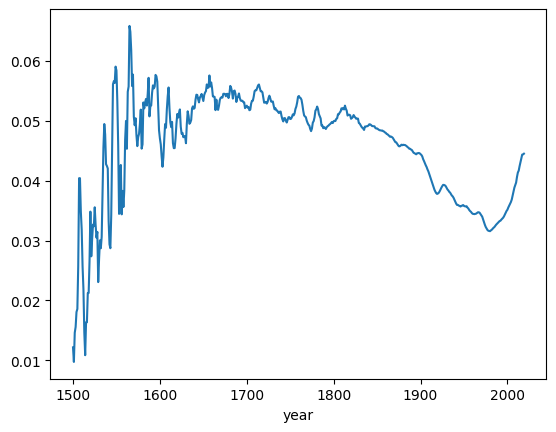

In [7]:
name_ngrams_df.sum(axis=1).plot()

In [55]:
len(names_done)

18055

In [49]:
name_ngrams_df = getNgrams('theo,noah', corpus='eng_gb_2019', caseInsensitive=True)[2]
working_columns = ['year'] + [x for x in [x for x in name_ngrams_df.columns if len(x) >= 7] if x[-6:] == " (All)"]
name_ngrams_df = name_ngrams_df[working_columns]
name_ngrams_df.columns = ['year','theo','noah']
name_ngrams_df.to_parquet('name_ngrams_df.parquet')
names_done = ['theo','noah']

In [146]:
ngrams_names = list(set(list_names)-set(name_ngrams_df.columns))

In [50]:
ngrams_names

NameError: name 'ngrams_names' is not defined

In [97]:
len(name_ngrams_df.columns)

26

In [81]:
ngrams_names = list(set(list_names)-set(name_ngrams_df.columns))
len(ngrams_names)

18053

In [51]:
len(set(list_names)-set(name_ngrams_df.columns))

18053

In [57]:
working_df = getNgrams((",").join(list_names[:40]), corpus='eng_gb_2019', caseInsensitive=True)[2]



Index(['year', 'claude (All)', 'Claude', 'CLAUDE', 'Rhyse', 'kerris (All)',
       'Kerris', 'KERRIS', 'kerris', 'suni (All)', 'Suni', 'suni', 'SUNI',
       'sunI', 'SunI', 'jaspa (All)', 'JASPA', 'Jaspa', 'Bedirhan',
       'annelies (All)', 'Annelies', 'ANNELIES', 'sully (All)', 'sully',
       'Sully', 'SULLY', 'seren (All)', 'seren', 'Seren', 'SEREN',
       'aluna (All)', 'Aluna', 'aluna', 'ALuna', 'ALUNA', 'safari (All)',
       'safari', 'Safari', 'SAFARI', 'Haroldas'],
      dtype='object')

In [74]:
working_columns = [x for x in [x for x in working_df.columns if len(x) >= 7] if x[-6:] == " (All)"]
working_df = working_df[working_columns]
working_df.columns = [x[:-6] for x in working_df.columns]
name_ngrams_df

,theo,noah,claude,kerris,suni,jaspa,annelies,sully,seren,aluna,safari
0,0.000000,0.000000,1.403440e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
1,0.000000,0.000000,1.122752e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
2,0.000000,0.000000,9.356270e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
3,0.000000,0.000000,8.019660e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
4,0.000003,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
515,0.000005,0.000011,5.645993e-06,4.766515e-08,5.778203e-08,5.126133e-09,3.695411e-08,0.000001,1.721394e-07,2.087518e-08,0.000002
516,0.000005,0.000011,5.769092e-06,4.117896e-08,5.596017e-08,5.531889e-09,3.992565e-08,0.000001,1.901199e-07,1.708493e-08,0.000001
517,0.000005,0.000012,5.805847e-06,4.704389e-08,5.750163e-08,6.119535e-09,4.104908e-08,0.000001,2.075830e-07,1.523263e-08,0.000001
518,0.000005,0.000012,5.860345e-06,2.460582e-08,5.341651e-08,6.933983e-09,4.192762e-08,0.000001,2.225952e-07,1.237124e-08,0.000001


In [77]:
working_df

,claude,kerris,suni,jaspa,annelies,sully,seren,aluna,safari
0,1.403440e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
1,1.122752e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
2,9.356270e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
3,8.019660e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...
515,5.645993e-06,4.766515e-08,5.778203e-08,5.126133e-09,3.695411e-08,0.000001,1.721394e-07,2.087518e-08,0.000002
516,5.769092e-06,4.117896e-08,5.596017e-08,5.531889e-09,3.992565e-08,0.000001,1.901199e-07,1.708493e-08,0.000001
517,5.805847e-06,4.704389e-08,5.750163e-08,6.119535e-09,4.104908e-08,0.000001,2.075830e-07,1.523263e-08,0.000001
518,5.860345e-06,2.460582e-08,5.341651e-08,6.933983e-09,4.192762e-08,0.000001,2.225952e-07,1.237124e-08,0.000001
